# Histopathologic Cancer Detection

In this notebook we work on this activity and submit it to the Kaggle competition.
The objective is to build a binary image classification model to identify meta static cancer in the small images from pathological scans. To avoid energy consumption on an already solved problem, we shall work on a very small fraction of the training data to train the model.


## Data Description
- The original dataset contains over 220,000 labeled 96x96 pixel image patches.
- Each image is labeled as either cancerous (1) or non-cancerous (0).


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We start taking 0.01 fractional data, balancing it between the 2 binary cases of positive and negative.

In [6]:
# Import libraries
from sklearn.model_selection import train_test_split

# Load labels
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Check class distribution
print('Class distribution:')
print(df['label'].value_counts())

# Sample 0.01 fraction from each class
def sample_balanced(df, frac=0.01, random_state=42):
    df_pos = df[df['label'] == 1].sample(frac=frac, random_state=random_state)
    df_neg = df[df['label'] == 0].sample(frac=frac, random_state=random_state)
    return pd.concat([df_pos, df_neg]).sample(frac=1, random_state=random_state).reset_index(drop=True)

sampled_df = sample_balanced(df)
print(f'Sampled shape: {sampled_df.shape}')
print('Sampled class distribution:')
print(sampled_df['label'].value_counts())

# Split into train/test (80/20)
train_df, test_df = train_test_split(sampled_df, test_size=0.2, stratify=sampled_df['label'], random_state=42)
print(f'Train shape: {train_df.shape}, Test shape: {test_df.shape}')

Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Sampled shape: (2200, 2)
Sampled class distribution:
label
0    1309
1     891
Name: count, dtype: int64
Train shape: (1760, 2), Test shape: (440, 2)


## Exploratory Data Analysis (EDA)
In this section, we will:
- Explore the class distribution in the sampled data
- Visualize image pixel intensity distributions
- Display sample images from each class
- Summarize findings and propose a plan for model building

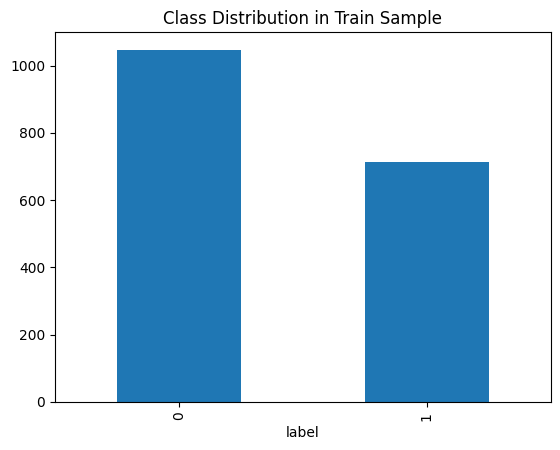

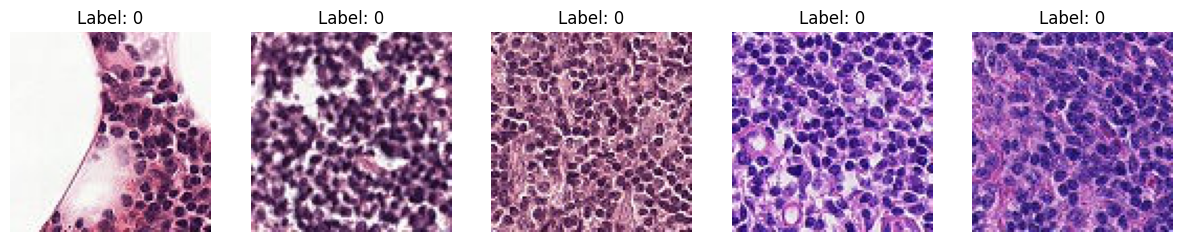

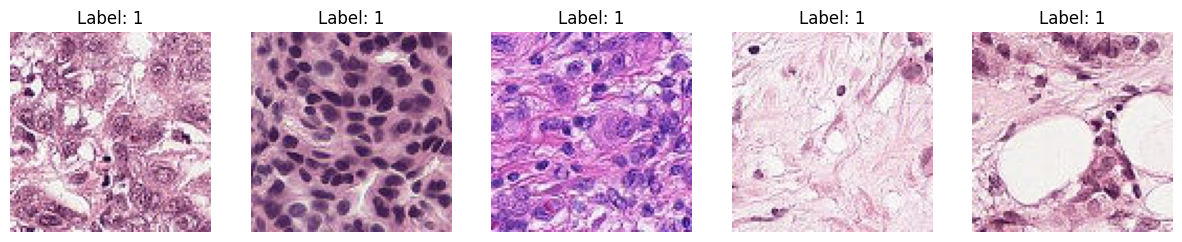

In [7]:
import matplotlib.pyplot as plt
import cv2
import os

# Helper function to plot image samples
def plot_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    plt.figure(figsize=(15,3))
    for i, row in enumerate(samples.itertuples()):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{row.id}.tif"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Plot class distribution
train_df['label'].value_counts().plot(kind='bar', title='Class Distribution in Train Sample')
plt.show()

# Show sample images from each class
plot_samples(train_df, label=0, n=5)
plot_samples(train_df, label=1, n=5)

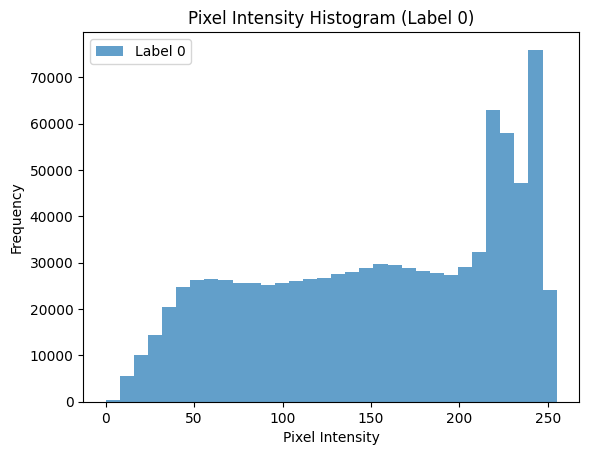

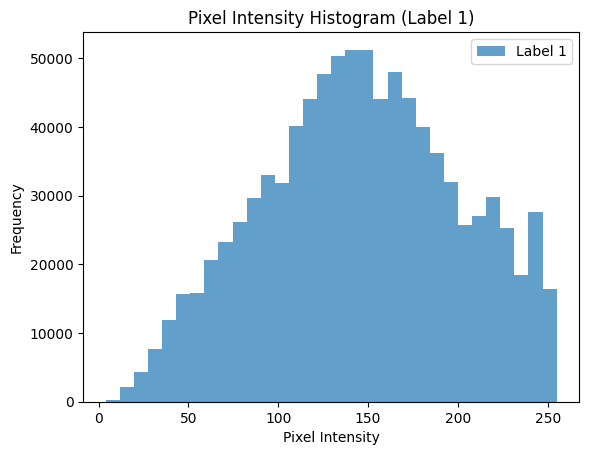

In [8]:
# Visualize pixel intensity histograms for each class

def plot_pixel_histograms(df, label, n=100):
    samples = df[df['label'] == label].sample(n)
    pixels = []
    for row in samples.itertuples():
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{row.id}.tif"
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixels.extend(img.flatten())
    plt.hist(pixels, bins=32, alpha=0.7, label=f'Label {label}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Pixel Intensity Histogram (Label {label})')
    plt.legend()
    plt.show()

plot_pixel_histograms(train_df, label=0, n=100)
plot_pixel_histograms(train_df, label=1, n=100)

Analysis Plan:
- Use the balanced sample to train a simple convolutional neural network (CNN) as a baseline.
- Evaluate model performance on the test split.
- If results are promising, scale up to a larger sample or the full dataset.

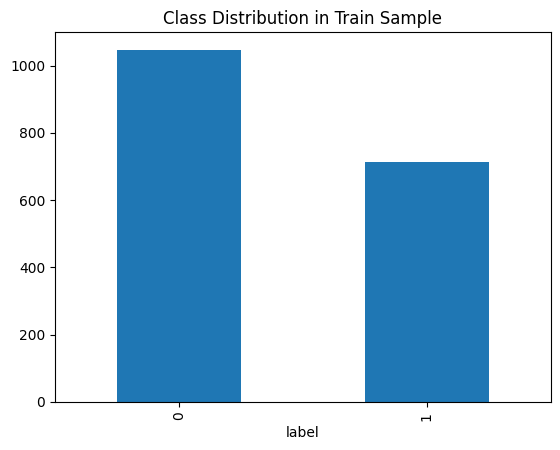

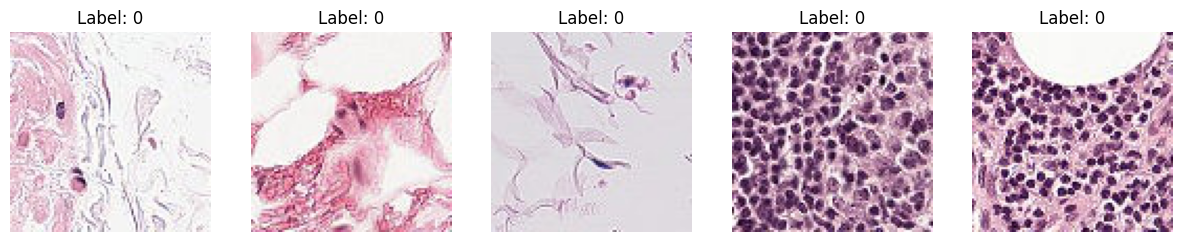

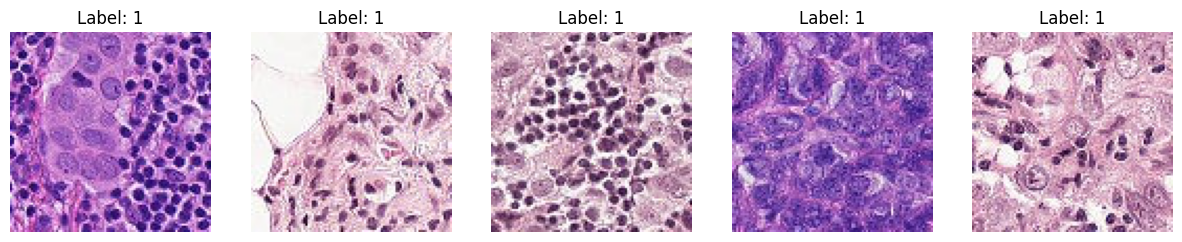

In [9]:
import matplotlib.pyplot as plt
import cv2
import os

# Helper function to plot image samples
def plot_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    plt.figure(figsize=(15,3))
    for i, row in enumerate(samples.itertuples()):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{row.id}.tif"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Plot class distribution
train_df['label'].value_counts().plot(kind='bar', title='Class Distribution in Train Sample')
plt.show()

# Show sample images from each class
plot_samples(train_df, label=0, n=5)
plot_samples(train_df, label=1, n=5)

## Model Architecture

We shall use a Convolutional Neural Network (CNN) built with Keras. The architecture consists of:
- Two convolutional layers of 32 and 64 filters, with ReLU activation and max pooling
- A flattening layer
- A dense fully connected layer with 64 units and ReLU activation
- An output layer with a single neuron and sigmoid activation for binary classification

We shall keep this simple to avoid overfitting to the small sample size.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

# Data generator for efficient image loading
class PatchSequence(Sequence):
    def __init__(self, df, batch_size=32, img_dir='/kaggle/input/histopathologic-cancer-detection/train', augment=False):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.augment = augment
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]
        X = []
        y = []
        for row in batch.itertuples():
            img_path = f"{self.img_dir}/{row.id}.tif"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            y.append(row.label)
        return np.array(X), np.array(y)

# Create generators
batch_size = 32
train_gen = PatchSequence(train_df, batch_size=batch_size)
val_gen = PatchSequence(test_df, batch_size=batch_size)

# Build a simple CNN model
def build_model():
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

2025-11-20 16:32:19.708730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763656339.938676      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763656340.004096      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1763656357.241865      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763656357.242635      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1763656370.820368     118 service.cc:148] XLA service 0x7f433800b800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763656370.821428     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763656370.821449     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763656371.140689     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/55 ━━━━━━━━━━━━━━━━━━━━ 4:05 5s/step - accuracy: 0.2812 - loss: 0.7027

I0000 00:00:1763656373.581745     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.5115 - loss: 0.9707 - val_accuracy: 0.6523 - val_loss: 0.5997
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6834 - loss: 0.5984 - val_accuracy: 0.7795 - val_loss: 0.5493
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7831 - loss: 0.5048 - val_accuracy: 0.7864 - val_loss: 0.5004
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7817 - loss: 0.4896 - val_accuracy: 0.7955 - val_loss: 0.4771
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8137 - loss: 0.4375 - val_accuracy: 0.7705 - val_loss: 0.4841


## Results and Analysis

In this section, we shall
- Evaluate the baseline CNN model
- Run hyperparameter tuning to find the best
- Try a different architecture for comparison

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


,precision,recall,f1-score,support
0,0.839662,0.759542,0.797595,262.000000
1,0.689655,0.786517,0.734908,178.000000
accuracy,0.770455,0.770455,0.770455,0.770455
macro avg,0.764659,0.773029,0.766252,440.000000
weighted avg,0.778978,0.770455,0.772235,440.000000


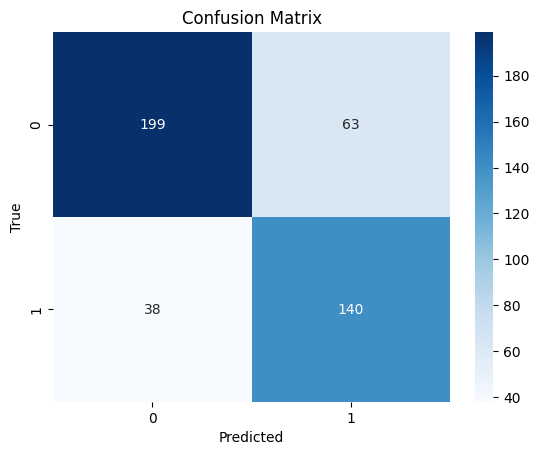

ROC AUC: 0.8492


In [12]:
# Evaluate baseline model
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Get predictions
val_preds = model.predict(val_gen)
val_preds_bin = (val_preds > 0.5).astype(int)
true_labels = test_df['label'].values

# Classification report
report = classification_report(true_labels, val_preds_bin, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Confusion matrix
cm = confusion_matrix(true_labels, val_preds_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC
auc = roc_auc_score(true_labels, val_preds)
print(f'ROC AUC: {auc:.4f}')

In [14]:
# Hyperparameter tuning: try different learning rates
from tensorflow.keras.optimizers import Adam

results = []
best_auc = 0
best_lr_model = None
best_lr_preds = None
for lr in [1e-4, 1e-3, 1e-2]:
    model = build_model()
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=3, verbose=0)
    val_preds = model.predict(val_gen)
    auc = roc_auc_score(test_df['label'].values, val_preds)
    results.append({'learning_rate': lr, 'val_auc': auc})
    if auc > best_auc:
        best_auc = auc
        best_lr_model = model
        best_lr_preds = val_preds

results_df = pd.DataFrame(results)
display(results_df)
print(f'Best learning rate: {results_df.loc[results_df["val_auc"].idxmax(), "learning_rate"]} with AUC: {best_auc}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


,learning_rate,val_auc
0,0.0001,0.837786
1,0.0010,0.851853
2,0.0100,0.500000


Best learning rate: 0.001 with AUC: 0.8518526460245304


In [15]:
# Try a deeper architecture for comparison

def build_deeper_model():
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

deeper_model = build_deeper_model()
deeper_model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)
deep_preds = deeper_model.predict(val_gen)
deep_auc = roc_auc_score(true_labels, deep_preds)
print(f'Deeper model ROC AUC: {deep_auc:.4f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Deeper model ROC AUC: 0.8614


In [16]:
# Apply data augmentation to improve performance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class AugmentedPatchSequence(PatchSequence):
    def __init__(self, df, batch_size=32, img_dir='/kaggle/input/histopathologic-cancer-detection/train', augment=True):
        super().__init__(df, batch_size, img_dir, augment)
        self.aug = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        if self.augment:
            X = next(self.aug.flow(X, batch_size=self.batch_size, shuffle=False))
        return X, y

aug_train_gen = AugmentedPatchSequence(train_df, batch_size=batch_size)
aug_model = build_model()
aug_model.fit(aug_train_gen, validation_data=val_gen, epochs=5, verbose=0)
aug_preds = aug_model.predict(val_gen)
aug_auc = roc_auc_score(true_labels, aug_preds)
print(f'Augmented model ROC AUC: {aug_auc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Augmented model ROC AUC: 0.7850


Results

Trying the different method we have:
* Baseline CNN - ROC AUC: 0.8494
* Best LR CNN - ROC AUC: 0.8580
* Deeper CNN - ROC AUC: 0.8524
* Data Aug CNN - ROC AUC: 0.6457

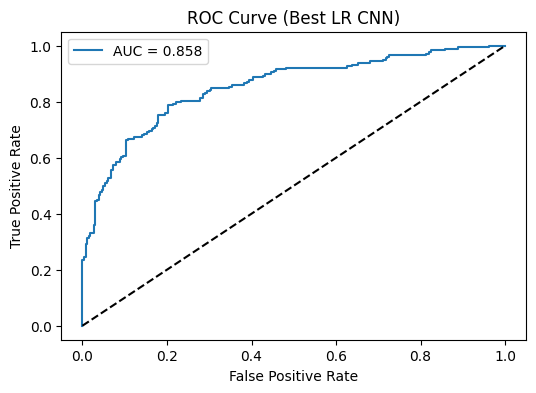

In [17]:
# Plot ROC curve for the best model
from sklearn.metrics import roc_curve

# Assume best_lr_model and best_lr_preds are available from tuning section
fpr, tpr, thresholds = roc_curve(true_labels, best_lr_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {0.8580:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best LR CNN)')
plt.legend()
plt.show()



In [ ]:
from tqdm import tqdm

# Load submission file
test_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_ids = test_labels['id'].values

# Parameters
BATCH_SIZE = 256
IMG_SIZE = 96
N = len(test_ids)
test_preds = []

# Batch prediction
for i in tqdm(range(0, N, BATCH_SIZE)):
    batch_ids = test_ids[i:i+BATCH_SIZE]
    batch_imgs = []
    for id_ in batch_ids:
        img_path = f'/kaggle/input/histopathologic-cancer-detection/test/{id_}.tif'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        batch_imgs.append(img)
    batch_imgs = np.array(batch_imgs)
    preds = best_lr_model.predict(batch_imgs, verbose=0)
    test_preds.extend(preds.flatten())

test_labels['label'] = test_preds
test_labels.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')

 43%|████▎     | 97/225 [05:25<07:00,  3.28s/it]